# Projet python : Interaction neutron-silicium

In [1]:
#/bin/bash
%pip install uv
%uv pip install tqdm numpy matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Using Python 3.13.3 environment at: /home/n/venv
Audited 3 packages in 2ms
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from math import prod

In [3]:
class bcolors: 
    #Kinda steel this to blender python script. Python provide some caracters that color the output made by the print func.
    #We are making here a class that make those orginized and easy to acces and read which make our code clear.
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Les Classes

Les classes du projet sont défini ci-dessous :

- Vector : C'est un vecteur
    - Attributs
        - x : coodronnée x
        - y : coordonnée y
        - z : coordonnée z
    - Méthodes :
        - get_lenght() : Retourne la norme du vecteur

- Sub_products : Contient un sous produit de la reaction
    - name : Le nom du sous produit
    - energy : L'énergie du sous produit
    - vector : Vecteur directionnel de la particule

- Reaction : Contient tout ce qu'il faut savoir sur une réaction
    - Attributs : 
        - eq_reac : Liste de chaques mots de l'équation de réaction
        - vector : Vecteur position de la reaction
        - sub_products : NdArray des sous produits de la reaction
        - reaction_type : Type de la reaction
        - nb_sub_products : Nombre de sous produits de la reaction
    - Methodes :
        - __get_reac(self) : Retourne une liste des noms des reactifs
        - __get_subproducts_name(self) : Retourne une liste des noms sous produits
        - __get_reaction_type(self) : Set reaction_type avec la bonne valeur

- Fichier : Contient les infos importantes d'un fichier
    - Attributs : 
        - energy : energie du fichier (par exemple 14MeV, 500MeV).
        - name : nom du fichier.
        - reactions_types : dictionnaire où il y a les types de réaction en clé et leur nombre en valeur.
        - nb_sec_sorted : dictionnaire où l'on a chaque nom de sous-produit en clé et le nombre de fois où il apparaît.
        - nb_sec_sorted_limited : même dictionnaire qu'au dessus mais cette fois-ci sans les sous-produits dont le nombre est inférieur à la limite fixée.
        - energy_limited : indique les différentes énergies que prend un sous-produit pour chaque sous-produit, avec toujours une limite imposée.
        - products_kind_type: dict = indique combien de fois apparaît chaque sous produit dans chaque type de réaction ('Al' apparaît 200 fois dans Absoprtion par exemple).
        - en_minimum : entier correspondant à la plus basse énergie dans tous les sous-produits du fichier.
        - en_maximum : entier correspondant à la plus haute énergie dans tous les sous-produits du fichier.
    - Méthodes :
        - __reactions_types : retourne le dictionnaire reactions_types.
        - __nb_tot_sec : retourne le nombre total de sous-produit dans le fichier.
        - __lvl_energy : retourne le dictionnaire energy_limited.
        - __extremum_of_energy : retourne les entiers en_minimum et en_maximum.
        - __secondaries_by_kind : retourne le(s) dictionnaire(s) products_kind_type

In [4]:
class Fichier:
    def __str__(self):
        return self.name
    
    def __reactions_types(self, content: list):
        temp = [i.reaction_type for i in content]
        temp = sorted(temp)
        temp_set = sorted(list(set(temp)))
        try:
            for i in range(1, len(temp_set)):
                self.reactions_types[temp[temp.index(temp_set[i-1])]] = temp.index(temp_set[i]) - temp.index(temp_set[i-1])
        except IndexError:
            self.reactions_types[temp[0]] = len(temp)
        except KeyboardInterrupt:
            quit()
        finally:
            self.reactions_types[temp[-1]] = len(temp) - temp.index(temp_set[-1])
            del(temp, temp_set)
    
    def limit(self, content: list):
        "Used to determine which limit of occurences do we take for secondaries"
        nb_tot_secondaries = self.nb_tot_secondaries
        limit = nb_tot_secondaries*0.15
        return limit
    
    
    def __nb_tot_sec(self, content: list):
        "Used to determine how many reactions there are in the file"
        type_reac = self.nb_sec_sorted
        self.nb_tot_secondaries = sum(i for i in type_reac.values()) 
        
    
    def __secondaries_by_kind(self, content: list):
        "Used to determine how many of each kind of secondary there are in each kind of reaction"
        self.products_kind_type = {i : {} for i in self.reactions_types.keys()}
        for reaction in content:
            for keys in self.reactions_types.keys():
                for i in reaction.sub_products:
                    if reaction.reaction_type == keys:
                        if i.name not in self.products_kind_type[keys].keys():
                            self.products_kind_type[keys][i.name] = 1
                        else:
                            self.products_kind_type[keys][i.name] += 1
    
    def __nb_sec_by_type_of_sec(self, content: list) -> dict:    #by Oscar
        "Used to determine the number of each kind of sub-product"
        nb_sec = {}
        for reaction in content:
            for i in reaction.sub_products:
                if i.name not in nb_sec:
                    nb_sec[i.name] = 1
                else:
                    nb_sec[i.name] += 1
        self.nb_sec_sorted = dict(sorted(nb_sec.items(), key=lambda item:item[1]))
    
    def __galette(self, content):
        self.galette = np.array([np.array([i.vecteur.x, i.vecteur.y, i.vecteur.z]) for i in content[:10000]]).T


    def __nb_sec_by_type_of_sec_limited(self, content: list) -> dict:
        "Used to apply the limit on the dict nb_sec_sorted"
        limite = self.limit
        self.nb_sec_sorted_limited = {}
        nb_sec_sorted = self.nb_sec_sorted
        for key, value in nb_sec_sorted.items():
            if value >= limite:
                self.nb_sec_sorted_limited[key] = value
        
    def __lvl_energy(self, content: list) -> list:
        "indicate the amount of energy for each sub product"
        limite = self.limit(content)
        energy={}
        energy_limited = {}
        for reaction in content:
            for i in reaction.sub_products:
                if i.name not in energy:
                    energy[i.name]=[i.energy]
                else:
                    energy[i.name].append(i.energy)
        for key, value in energy.items():
            if len(value) >= limite:
                energy_limited[key] = value
        self.energy_limited = energy_limited
        del(limite, energy, energy_limited)
    
    """
    def __merging_secondaries(self, content: list) -> dict:
        liste_secondaries_to_merge = ['Si', 'Mg', 'Al']
        energy_limited = self.energy_limited
        energy_limited_merged = {}
        for i in liste_secondaries_to_merge:
            energy_limited_merged[i] = []
            for key, value in energy_limited.items():
                if i in key:
                    energy_limited_merged[i] = energy_limited[i] + value
        self.energy_limited_merged = energy_limited_merged
    """
    
    def __extremum_of_energy(self, content: list) -> list:
        "Used to create a list with all of the energies of the secondaries in the file"
        energy_limited = self.energy_limited
        all_the_energy = []
        for energies in energy_limited.values():
            for value in energies:
                all_the_energy.append(value)
        self.en_minimum = min(i for i in all_the_energy)
        self.en_maximum = max(i for i in all_the_energy)
    
    def __init__(self, name, content, energy):
        #attribut : 
        self.energy: int = energy
        self.name: str = name
        self.nb_tot_secondaries: int = 0
        self.reactions_types: dict = {}
        self.nb_sec_sorted: dict = {}
        self.nb_sec_sorted_limited: dict = {}
        self.energy_limited: dict = {}
        self.products_kind_type: dict = {}
        self.galette: NdArray = None
        #self.energy_limited_merged:dict = {}
        self.en_minimum: int = 0
        self.en_maximum: int = 0
        
        #appel des méthodes : 
        self.__reactions_types(content)
        self.__lvl_energy(content)
        #self.__merging_secondaries(content)
        self.__extremum_of_energy(content)
        self.__secondaries_by_kind(content)
        self.__nb_sec_by_type_of_sec(content)
        self.__galette(content)
        self.__nb_tot_sec(content)


class Vecteur:
    def __str__(self):
        return f"{self.x}, {self.y}, {self.z}"

    def get_norm(self):
        return np.sqrt((self.x + self.y + self.z) ** 2)

    def __init__(self, x, y, z):
        self.x: float = float(x)
        self.y: float = float(y)
        self.z: float = float(z)

class Sub_product:
    def __init__(self, name: str, energy: float, vec: Vecteur):
        self.name: str = name
        self.energy: float = energy
        self.vecteur: Vecteur = vec

class Reaction: 
    def __get_reac(self) -> list: 
        return [i for i in self.eq_reac[1:self.eq_reac.index('-->')] if i != "+"]
    
    def __get_subproducts_name(self) -> list:
        return [i.name for i in self.sub_products]

    def __get_reaction_type(self) -> int:
        if self.eq_reac[0] == "hadElastic":
            self.reaction_type = "Elastic"
            return 0
        else:
            reac = self.__get_reac()
            sub_product = self.__get_subproducts_name()
            if reac[0] in sub_product and reac[1] in sub_product and len(set(sub_product)) == 3:
                self.reaction_type = "Inelastic"
                return 0
            self.reaction_type = "Absorption"
            return 0

    def __init__(self, vec: Vecteur, sub_products: list, eq_reac: list):
        # Attributs
        self.eq_reac: list[str] = eq_reac
        self.vecteur: Vecteur = vec
        self.sub_products: np.ndarray = np.array(sub_products)
        self.nb_sous_reactifs: int = len(self.sub_products)
        self.reaction_type: str = ""

        # Appel des méthodes
        self.__get_reaction_type()

# La lecture des fichiers :

Ici on vient lire les différents fichiers et les trier par energie croissante

In [5]:
def open_multiple_files(liste: list) -> list:
    files = []
    for i in tqdm(liste):
        reaction, energy, return_code = parser(i)
        if return_code != 0:
            print(f"{bcolors.FAIL} File {i} didn't process correctly {bcolors.ENDC}")
        else:
            files.append(Fichier(i, reaction, energy))
            del(reaction)
    files = [(int(i.energy), i) for i in files]
    files = np.array(sorted(files)).T
    return files[1]

def parser(file: str) -> tuple[np.ndarray, int, int]:
    """parse things"""
    liste=[""] #else there is out of range error due tu the liste[-1]+=line
    try:
        f = open(file, "r")
        data = f.read()
        f.close()
        if re.search(r"[^ -~\n]", data) != None:
            print(f"\n{bcolors.FAIL}Non ASCII character detected {bcolors.ENDC}")
            return (np.array(liste),0, -2)
        data = data.split('\n')
    except FileNotFoundError:
        print(f"{bcolors.FAIL}{file} : No such a directory file{bcolors.ENDC}")
        return (np.array(liste),0, -1)
    except:
        print(f"{bcolors.FAIL}Can't open file{bcolors.ENDC}")
        return (np.array(liste),0, -1)

    for line in data: #read file
        line += "\n" #weird but the progress bar
        if "[" in line:
            line = line.split("[")[0] + line.split("]")[1]
        if "---" in line:
            liste.append(line) #add each reaction line
        else:
            liste[-1]+=line
        
    del(data)
    if len(liste) == 1 :
        print("File contain one or less reaction")
        return (np.array(liste),0, -2)

    reactions = []

    energy = liste[1].split("\n")[1].split(" ")[6]

    for i in liste[1:]:
        v = [[a for a in j.split(" ") if a != ""] for j in i.split("\n") if j != ""]
        
        in_vec = Vecteur(v[1][0], v[1][1], v[1][2])

        eq_reac = v[0][2:]
        eq_reac = eq_reac[:-1]
        sub_products = [Sub_product(i[0], float(i[1]), Vecteur(i[2], i[3], i[4])) for i in v[2:]]
        reactions.append(Reaction(in_vec, sub_products, eq_reac))

    del(liste)
 
    return np.array(reactions), int(energy), 0

# Misc fonctions

In [6]:
def concatenate(data):
    temp = []
    for i in data:
        temp = temp + i
    return temp

def ploting_hist(names, titles, content, dims, fig_dims, lims = None, colors = None):
    plt.figure(figsize=fig_dims, dpi=100)
    if colors == None:
        colors = ["blue"] * len(titles)
    for i in range(len(titles)):
        plt.subplot(dims[0], dims[1], i+1)
        plt.tight_layout()
        plt.bar(range(len(names[i])), content[i], tick_label = names[i], color = colors[i])
        plt.xticks(rotation = 90)
        plt.title(titles[i])
        if lims != None:
            plt.ylim(lims[0], lims[1])
    plt.show()

# Appel des fichiers

Ici on définie où sont les fichiers et on les lis.

On obtient en fin une liste d'objet Fichier

In [7]:
liste = os.listdir("Secondaries_zips")
liste = ["Secondaries_zips/" + i for i in liste if "txt" in i]
files = open_multiple_files(liste)
print("Fichiers lus")

100%|██████████| 32/32 [01:03<00:00,  1.99s/it]

Fichiers lus


# Visualisation du problème :

On affiche une des galettes pour visualiser le pb

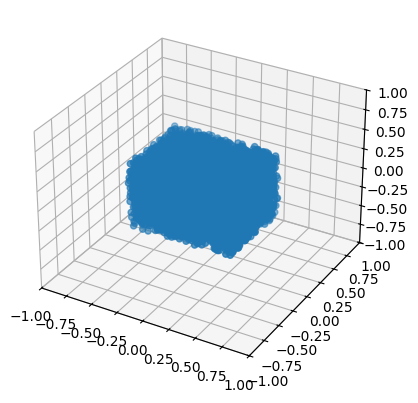

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set_xlim3d([-1,1])
ax.set_ylim3d([-1,1])
ax.set_zlim3d([-1,1])
i = np.array(files[15].galette)
ax.scatter(i[0], i[1], i[2])
plt.show()

# Affchage des types de réactions en fonction de l'énergie

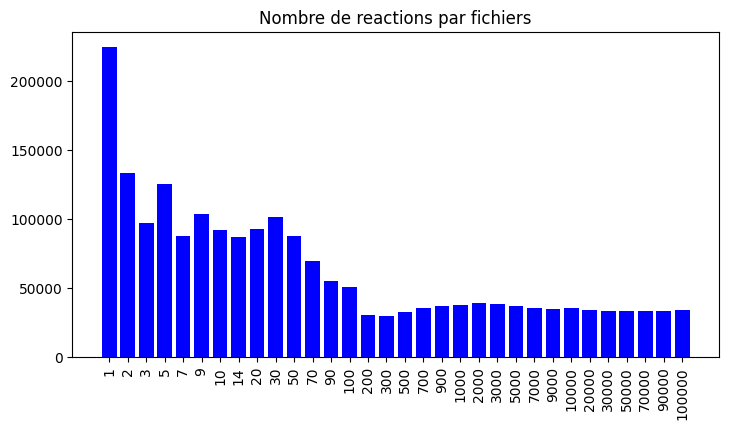

Nombre : 


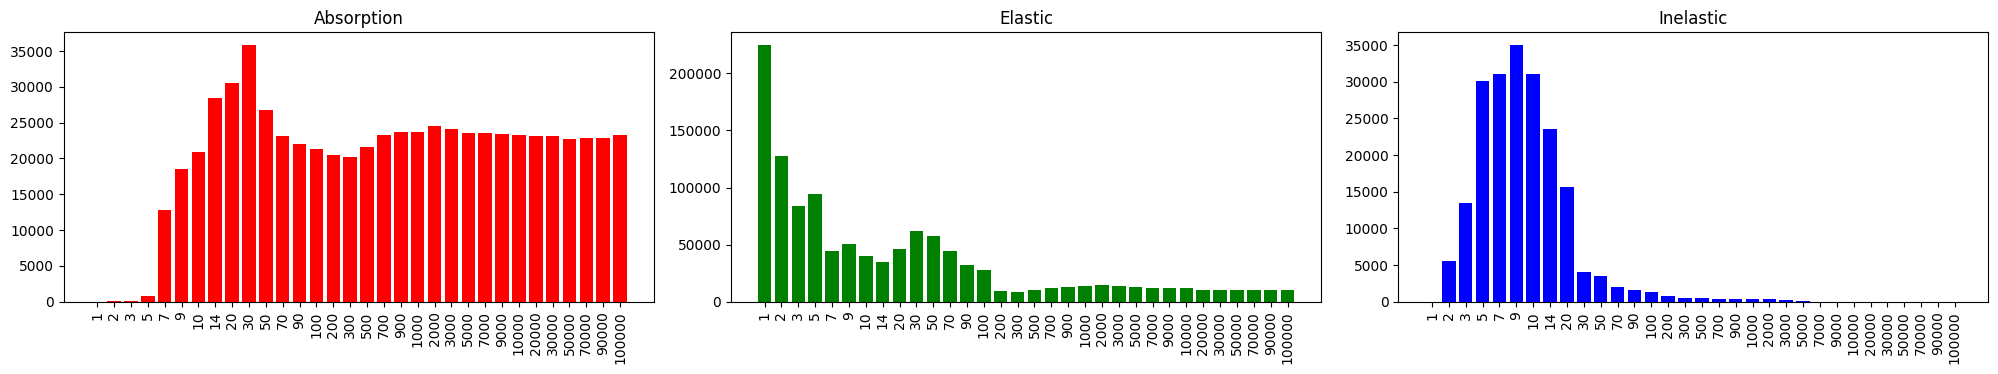

Pourcentage : 


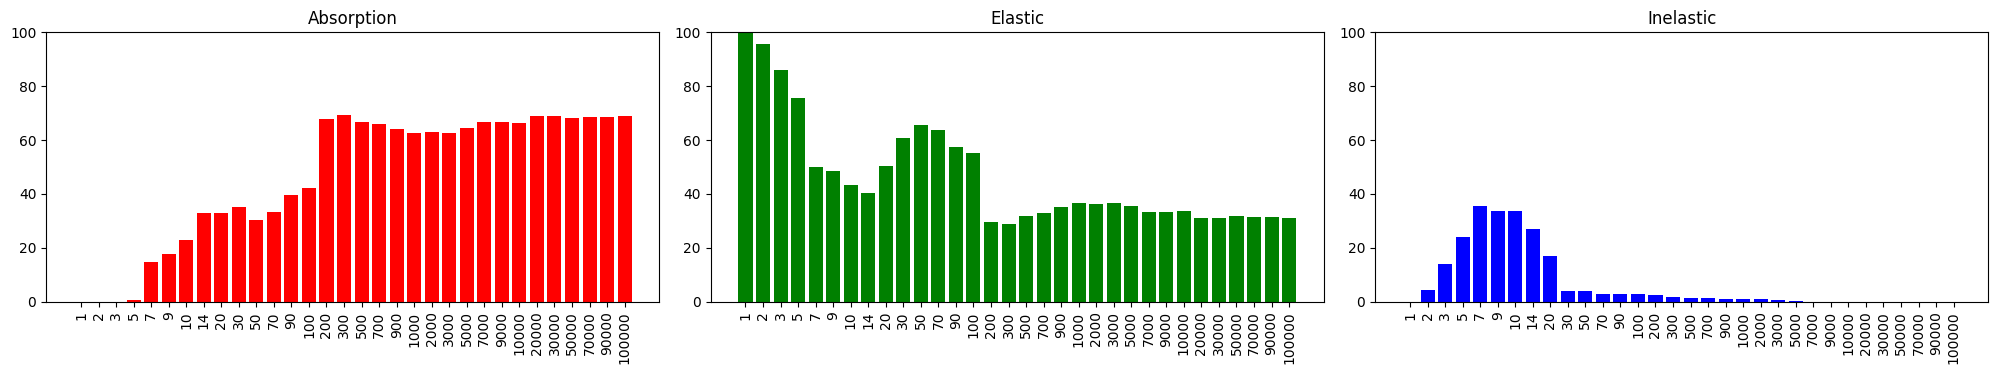

In [9]:
types = sorted(set(concatenate(list(i.reactions_types.keys()) for i in files)))

plot = []
for t in types:
    plot = plot + [np.array([(int(i.energy), i.reactions_types[t]) if (t in i.reactions_types.keys()) else (int(i.energy), 0) for i in files]).T]

plot = np.array(plot)
each_type = plot.flatten().reshape(plot.shape[0] * plot.shape[1], plot.shape[2]).T[:: ,1::2].T
S = each_type.sum(axis = 0)

percent = (each_type/S)*100

colors = ["red", "green", "blue"]

energies = plot[::, :1, ::].reshape(plot.shape[0], plot.shape[2])

ploting_hist(energies, ["Nombre de reactions par fichiers"], [S], (1, 1), (7.195, 3.841))

print("Nombre : ")

ploting_hist(energies, types, plot[::, 1:, ::].reshape(plot.shape[0], plot.shape[2]), (1, 3), (20.195, 3.841), colors = colors)

print("Pourcentage : ")

ploting_hist(energies, types, percent, (1, 3), (20.195, 3.841), lims = (0, 100), colors = colors)

# Affichage de la quantité de produits problématiques générés

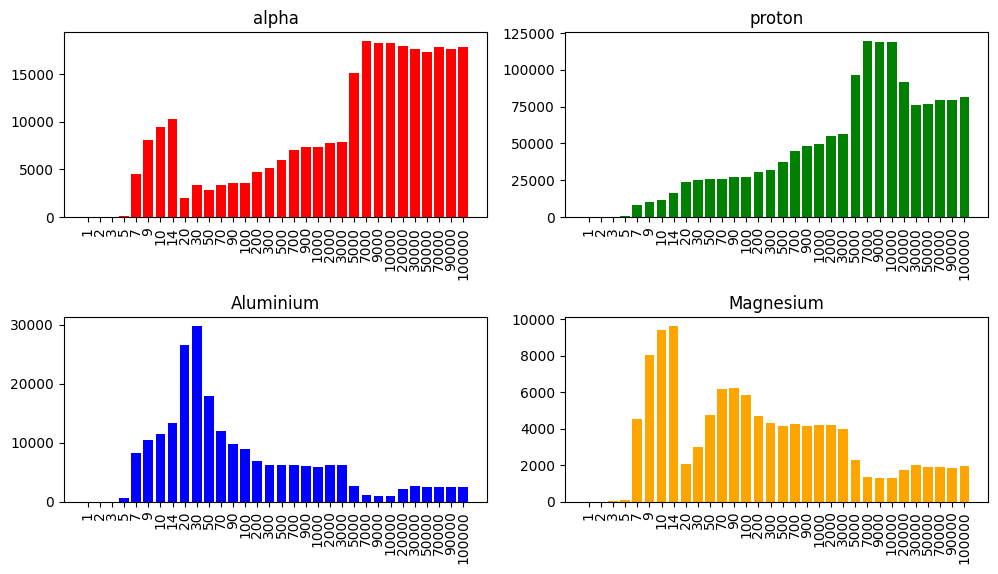

Pourcentage :


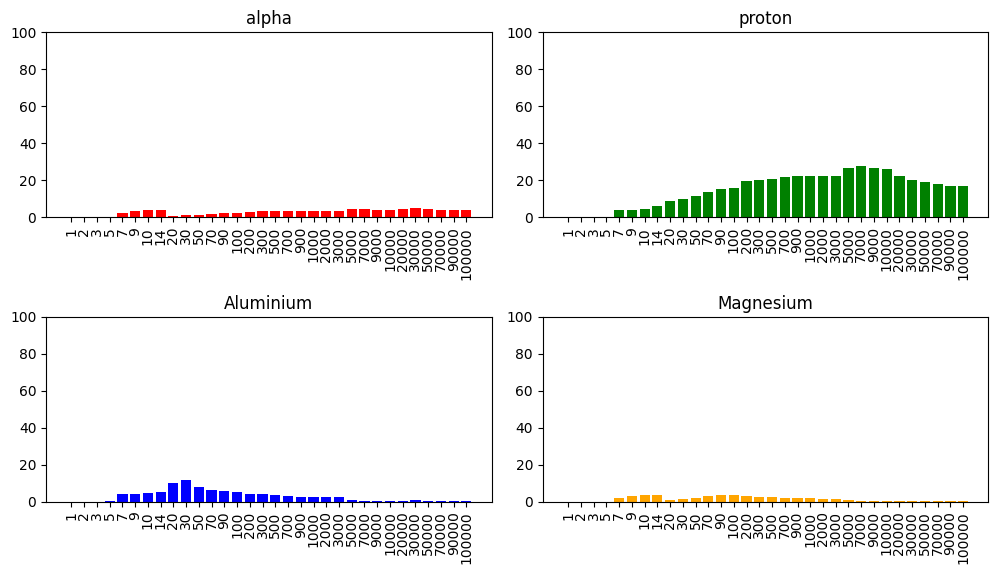

In [10]:
alpha = []
proton = []
Al = []
Mg = []
tot_secondaries = []

for i in files:
    alpha.append(dict(filter(lambda item: 'alpha' in item[0],i.nb_sec_sorted.items())))
    proton.append(dict(filter(lambda item: 'proton' in item[0],i.nb_sec_sorted.items())))
    Al.append(dict(filter(lambda item: 'Al' in item[0],i.nb_sec_sorted.items())))
    Mg.append(dict(filter(lambda item: 'Mg' in item[0],i.nb_sec_sorted.items())))
    tot_secondaries.append(i.nb_tot_secondaries)


alpha = np.array([0 if i == {} else i["alpha"] for i in alpha])
proton = np.array([0 if i == {} else i["proton"] for i in proton])
Al = np.array([0 if i == {} else sum(i.values()) for i in Al])
Mg = np.array([0 if i == {} else sum(i.values()) for i in Mg])

colors = ["red", "green", "blue", "orange"]

dic = {"alpha" : alpha, "proton" : proton, "Aluminium" : Al, "Magnesium" : Mg}

vals = np.array(list(dic.values()))
tot_secondaries = np.array(tot_secondaries)

percent = (vals/tot_secondaries)*100

ploting_hist([energies[0]] * len(dic.keys()), list(dic.keys()), list(dic.values()), (2,2), (10.195, 5.841), colors = colors)

print("Pourcentage :")

ploting_hist([energies[0]] * len(dic.keys()), list(dic.keys()), percent, (2, 2), (10.195, 5.841), lims = (0, 100), colors = colors)